In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct
from scipy.stats import binom, poisson, norm


mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = True
pathFigures = '/home/thea/MesterTesen/WrittenWork/Figures/'


import sys

sys.path.append('../../')
sys.path.append('../')

from GetCoreData_fct import GetCoreData
from BackDiffuse_LT import BackDiffuse
from Interpolation_Class import Interpolation
from HL_AnalyticThea_class import HL_Thea
from DiffusionProfiles_calculations import DiffusionLength
from transforms import transforms
from Decon import SpectralDecon
from sigmaSolver import sigma_Solver
from SignalAttenuation import Attenuation, AnnualLayerThick


def func_gaussian(x, N, mu, sigma, a):
    
    return N * norm.pdf(x, mu, sigma) + a

def avg(a):
    return a[a > 0].mean()
def std(a):
    return a[a>0].std()



In [3]:
sites = ['SiteA', 'SiteB','SiteD','SiteE','SiteG']

# BD with $\sigma_{fit}$


#########SiteA#########


<ipython-input-66-eb93d5a4fe27>:26: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  DataAll = GetCoreData(site, 'Alphabet')


sigma fit: 7.12 [cm]
sigma min: 7.69 [cm]
sigma max: 7.90 [cm]

#########SiteB#########


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-66-eb93d5a4fe27>:26: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  DataAll = GetCoreData(site, 'Alphabet')


sigma fit: 7.42 [cm]
sigma min: 7.58 [cm]
sigma max: 7.80 [cm]

#########SiteD#########


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-66-eb93d5a4fe27>:26: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  DataAll = GetCoreData(site, 'Alphabet')


sigma fit: 7.56 [cm]
sigma min: 7.36 [cm]
sigma max: 7.54 [cm]

#########SiteE#########


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-66-eb93d5a4fe27>:26: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  DataAll = GetCoreData(site, 'Alphabet')


sigma fit: 7.81 [cm]
sigma min: 8.85 [cm]
sigma max: 9.13 [cm]

#########SiteG#########


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-66-eb93d5a4fe27>:26: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  DataAll = GetCoreData(site, 'Alphabet')


sigma fit: 8.21 [cm]
sigma min: 8.85 [cm]
sigma max: 9.10 [cm]


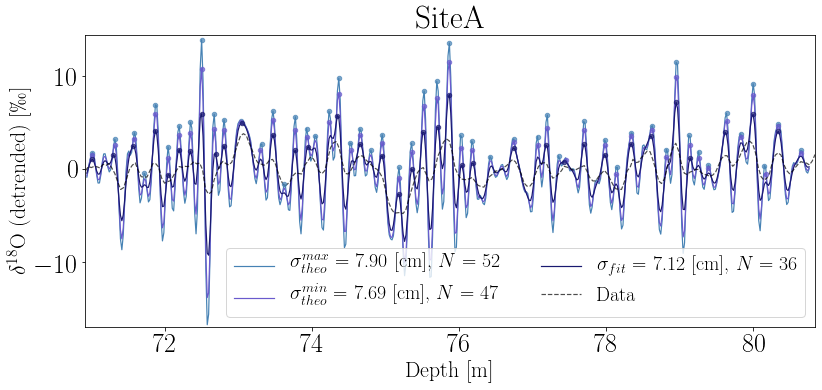

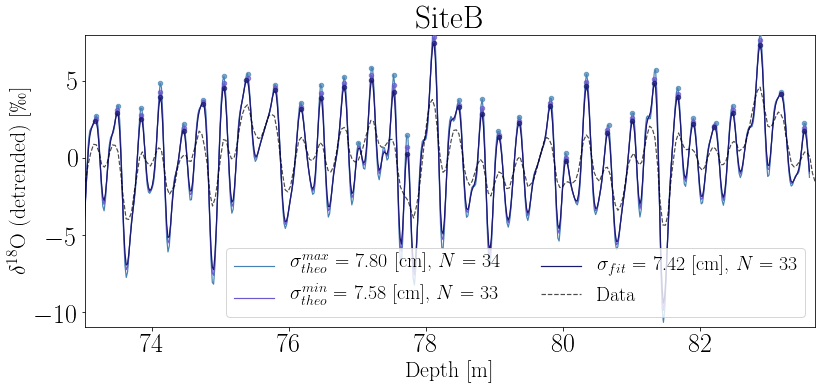

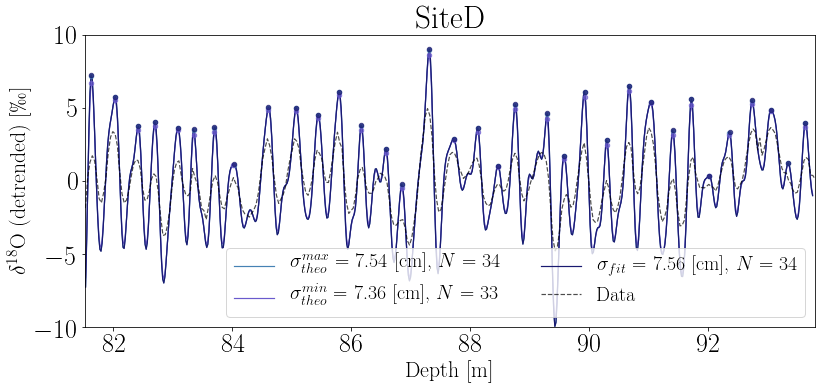

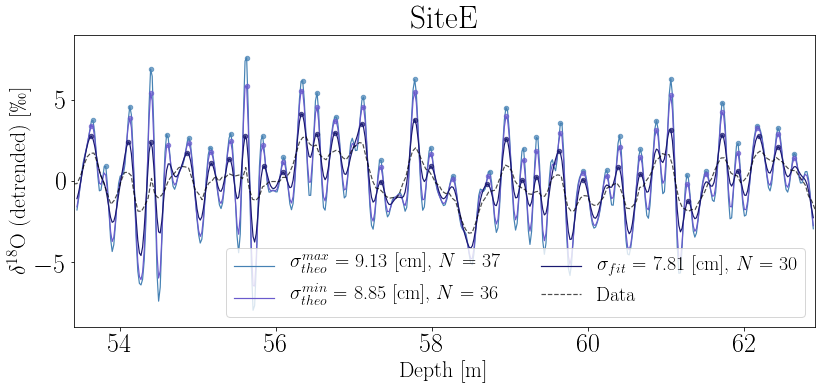

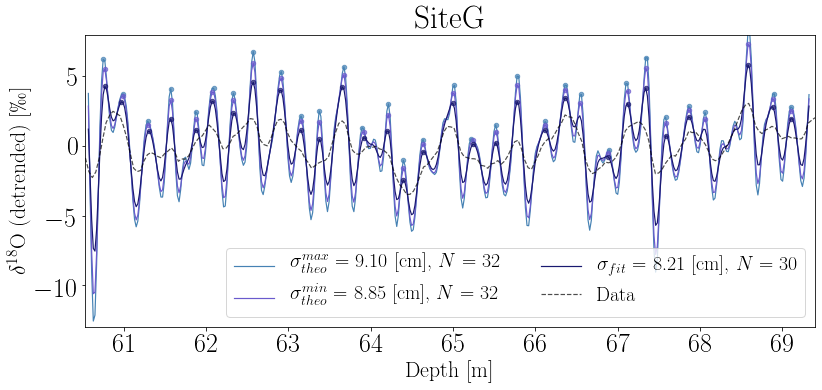

In [66]:
ymin = [-17, -11, -10, -9, -13]
ymax = [14.5, 8, 10, 9, 8]

i=0
mpl.rcParams['font.size'] = 26


for site in sites:
#    site = 'SiteG'
    print('\n#########'+site+'#########')
    N_InInt = 33

    CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

    coreNames = CoresSpecs['CoreName']


    core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
    CoreSpecs = CoresSpecs.iloc[core_idx]
    dTamb = CoreSpecs['dTamb']
    dLaki = CoreSpecs['dLaki']
    accum0 = CoreSpecs['Accum0']
    accumIE = CoreSpecs['Accum1']
    Temp0 = CoreSpecs['T0']

    DataAll = GetCoreData(site, 'Alphabet')

    data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
    data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
    data_dens = DataAll[4]; data_dens_LT = DataAll[5]
    data_diff = DataAll[6]; data_diff_LT = DataAll[7]


    depth = data_d18O['depth']
    d18O = data_d18O['d18O']

    depth_LT = data_d18O_LT['depth']
    d18O_LT = data_d18O_LT['d18O']
    dataAll = pd.DataFrame({'depth':depth,'d18O':d18O}, index=None)


    lSecs_in = 7
    shift_in=1.5

    pathResults = '/home/thea/MesterTesen/Analysis/ResultsGeneration/ResultsData/'
    data = pd.read_csv(pathResults + site + '_ALT_FullCore_Pshift_'+str(int(shift_in))+'_lSecs_'+str(lSecs_in)+'.csv')

    lDCT = np.asarray(data['lDCT']);lNDCT = np.asarray(data['lNDCT']);lFFT = np.asarray(data['lFFT']);
    vals_use = data['depth']

    lks = np.c_[lDCT,lNDCT,lFFT]
    lks_LT = lks[(vals_use>=min(depth_LT))&(vals_use<=max(depth_LT))]

    l_LT = avg(lks_LT)
    lStd_LT = std(lks_LT)

    lMean = data['lMean']
    lStd = data['lStd']
    vals_use = data['depth']


    inst = BackDiffuse(site, dataAll, CoresSpecs, dTamb, dLaki, N_InInt, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT, Dist=30, transType = 'NDCT')
    sigmaFit = inst.spectralEstimate()
    sigmaTheo = inst.diffLenEstimateHL()

    print(f'sigma fit: {sigmaFit*100:.2f} [cm]')
    print(f'sigma min: {sigmaTheo[0]*100:.2f} [cm]')
    print(f'sigma max: {sigmaTheo[1]*100:.2f} [cm]')

    newDepth, newData, pattern, Ps, Ts, diffLen = inst.BackDiffuse_manuel_constrained(sigma=sigmaFit,ALT_LT_in=l_LT)
    newDepth0, newData0, pattern0, Ps0, Ts0, diffLen0 = inst.BackDiffuse_manuel_constrained(sigma=sigmaTheo[0],ALT_LT_in=l_LT)
    newDepth1, newData1, pattern1, Ps1, Ts1, diffLen1 = inst.BackDiffuse_manuel_constrained(sigma=sigmaTheo[1],ALT_LT_in=l_LT)


    fig, ax = plt.subplots(figsize=(12,6))


    ax.plot(newDepth1,newData1, label='$\sigma_{theo}^{max}$'+f' = {diffLen1*100:.2f} [cm], $N=$ {len(Ps1)}', c='steelblue', lw=1.2)
    ax.plot(newDepth0,newData0, label='$\sigma_{theo}^{min}$'+f' = {diffLen0*100:.2f} [cm], $N=$ {len(Ps0)}', c='slateblue', lw=1.2)
    ax.plot(newDepth,newData, label='$\sigma_{fit}$'+f' = {diffLen*100:.2f} [cm], $N=$ {len(Ps)}', c='midnightblue', lw=1.2)



    ax.plot(np.asarray(depth_LT), np.asarray(d18O_LT)-np.mean(np.asarray(d18O_LT)), lw=1.2, label='Data', ls='--', color='k', alpha=0.7)

    ax.scatter(newDepth1[Ps1],newData1[Ps1], color='steelblue', s=20, alpha=0.7, zorder=3)
    ax.scatter(newDepth0[Ps0],newData0[Ps0], color='slateblue', s=20, alpha=0.7, zorder=3)
    ax.scatter(newDepth[Ps],newData[Ps], color='midnightblue', s=20, alpha=0.7, zorder=3)


    ax.set(title=site,xlim=(min(depth_LT),max(depth_LT)), ylim=(ymin[i],ymax[i]))
    ax.set_xlabel('Depth [m]', fontsize=22)
    ax.set_ylabel('$\delta^{18}$O (detrended) [$\permil$]', fontsize=22)

    
    ax.legend(fontsize=20, ncol=2, loc='lower right')

    fig.tight_layout()
    i += 1
    if saveFigs:
        fig.savefig(pathFigures+site+'_BDdata_SigmaFitSigmaTheo.pdf', bbox_inches='tight')

# BD with different $\sigma$s

<ipython-input-72-598bd9ab67c3>:25: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  DataAll = GetCoreData(site, 'Alphabet')


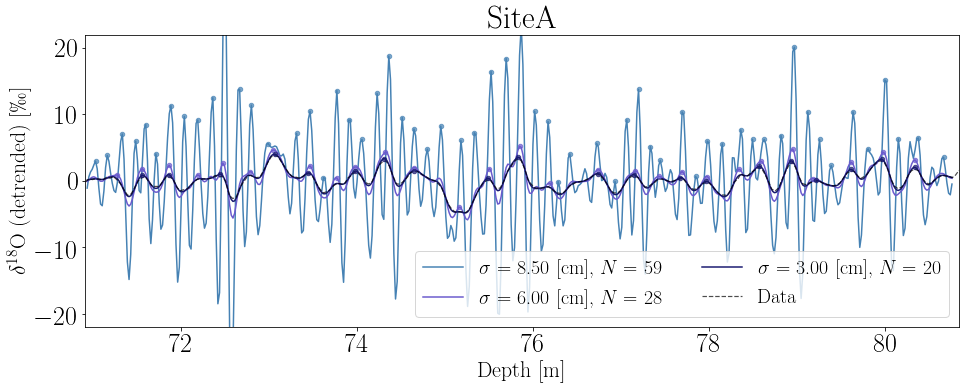

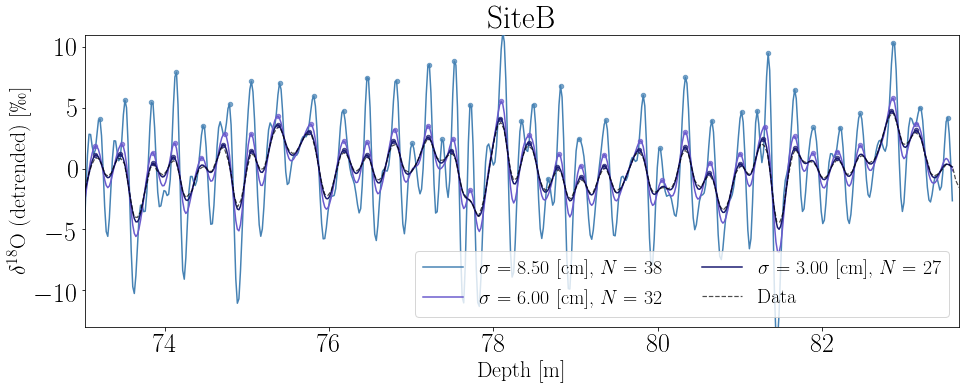

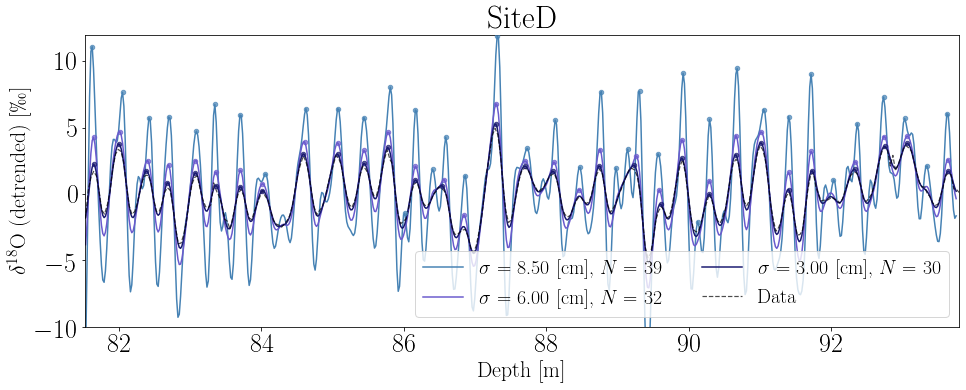

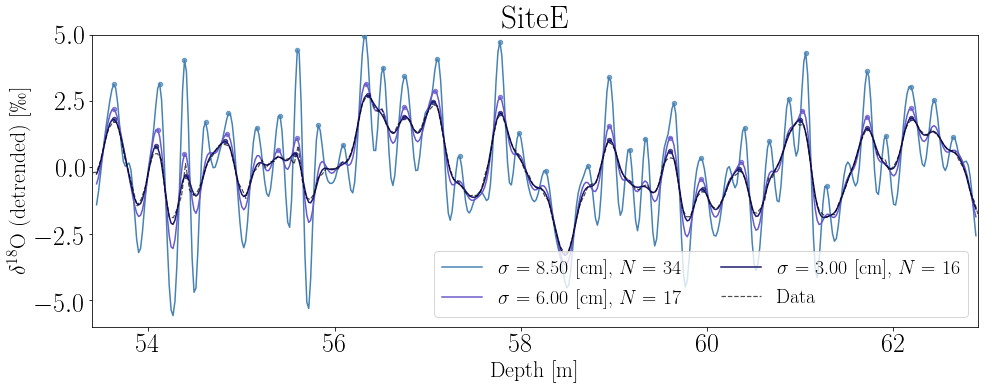

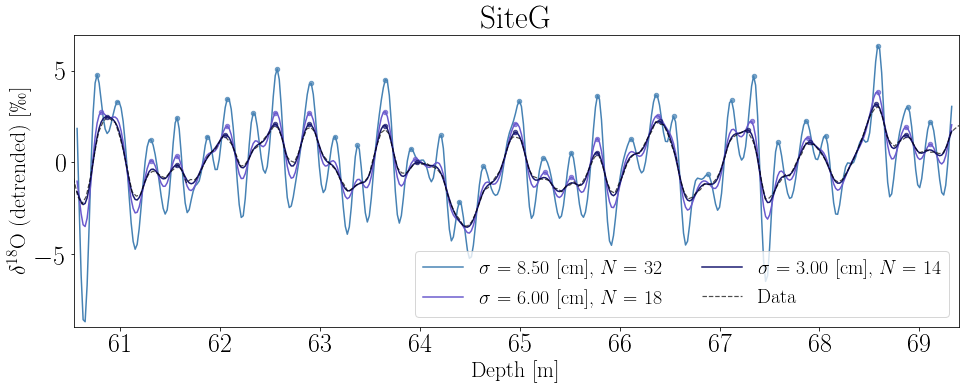

In [72]:
lSecs_in = 7
shift_in=1.5
N_InInt = 33

ymin = [-22, -13, -10, -6, -9]
ymax = [22, 11, 12, 5, 7]

i=0
for site in sites:
    #site = 'SiteG'

    CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

    coreNames = CoresSpecs['CoreName']


    core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
    CoreSpecs = CoresSpecs.iloc[core_idx]
    dTamb = CoreSpecs['dTamb']
    dLaki = CoreSpecs['dLaki']
    accum0 = CoreSpecs['Accum0']
    accumIE = CoreSpecs['Accum1']
    Temp0 = CoreSpecs['T0']

    DataAll = GetCoreData(site, 'Alphabet')

    data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
    data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
    data_dens = DataAll[4]; data_dens_LT = DataAll[5]
    data_diff = DataAll[6]; data_diff_LT = DataAll[7]


    depth = data_d18O['depth']
    d18O = data_d18O['d18O']

    depth_LT = data_d18O_LT['depth']
    d18O_LT = data_d18O_LT['d18O']

    dataAll = pd.DataFrame({'depth':depth,'d18O':d18O}, index=None)



    pathResults = '/home/thea/MesterTesen/Analysis/ResultsGeneration/ResultsData/'
    data = pd.read_csv(pathResults + site + '_ALT_FullCore_Pshift_'+str(int(shift_in))+'_lSecs_'+str(lSecs_in)+'.csv')

    lDCT = np.asarray(data['lDCT']);lNDCT = np.asarray(data['lNDCT']);lFFT = np.asarray(data['lFFT']);
    vals_use = data['depth']

    lks = np.c_[lDCT,lNDCT,lFFT]
    lks_LT = lks[(vals_use>=min(depth_LT))&(vals_use<=max(depth_LT))]

    l_LT = avg(lks_LT)
    lStd_LT = std(lks_LT)

    lMean = data['lMean']
    lStd = data['lStd']
    vals_use = data['depth']


    inst = BackDiffuse(site, dataAll, CoresSpecs, dTamb, dLaki, N_InInt, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT, Dist=30, transType = 'NDCT')
    newDepth2, newData2, pattern, Ps2, Ts, diffLen2 = inst.BackDiffuse_manuel_constrained(sigma=0.03,ALT_LT_in=l_LT)

    newDepth5, newData5, pattern, Ps5, Ts, diffLen5 = inst.BackDiffuse_manuel_constrained(sigma=0.06,ALT_LT_in=l_LT)

    newDepth7, newData7, pattern, Ps7, Ts, diffLen7 = inst.BackDiffuse_manuel_constrained(sigma=0.085,ALT_LT_in=l_LT)

    newDepth10, newData10, pattern, Ps10, Ts, diffLen10 = inst.BackDiffuse_manuel_constrained(sigma=0.08,ALT_LT_in=l_LT)


    fig, ax = plt.subplots(figsize=(14,6))



    #ax.plot(newDepth10,newData10, label='$\sigma$ = 10.0 [cm]', c='seagreen')
    ax.plot(newDepth7,newData7, label=f'$\sigma$ = {diffLen7*100:.2f} [cm], $N=$ {len(Ps7)}', c='steelblue')
    ax.plot(newDepth5,newData5, label=f'$\sigma$ = {diffLen5*100:.2f} [cm], $N=$ {len(Ps5)}', c='slateblue')
    ax.plot(newDepth2,newData2, label=f'$\sigma$ = {diffLen2*100:.2f} [cm], $N=$ {len(Ps2)}', c='midnightblue')
    ax.plot(np.asarray(depth_LT), np.asarray(d18O_LT)-np.mean(np.asarray(d18O_LT)), lw=1.2, label='Data', ls='--', color='k', alpha=0.7)

    #ax.scatter(newDepth10[Ps10],newData10[Ps10], color='lightseagreen', s=20, alpha=0.7, zorder=3)
    ax.scatter(newDepth7[Ps7],newData7[Ps7], color='steelblue', s=20, alpha=0.7, zorder=3)
    ax.scatter(newDepth5[Ps5],newData5[Ps5], color='slateblue', s=20, alpha=0.7, zorder=3)
    ax.scatter(newDepth2[Ps2],newData2[Ps2], color='midnightblue', s=20, alpha=0.7, zorder=3)

    ax.set(title=site,xlim=(min(depth_LT),max(depth_LT)), ylim=(ymin[i],ymax[i]))
    ax.set_xlabel('Depth [m]', fontsize=22)
    ax.set_ylabel('$\delta^{18}$O (detrended) [$\permil$]', fontsize=22)


    ax.legend(fontsize=20, ncol=2, loc='lower right')

    fig.tight_layout()
    fig.savefig(pathFigures+site+'_BDdata_3specificSigma.pdf', bbox_inches='tight')
    i+=1

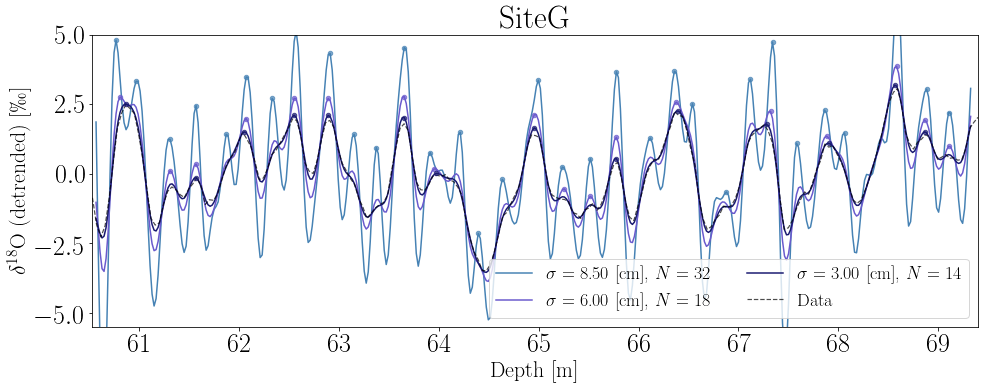

# Spectral Transforms

In [3]:
site = 'SiteA'
pathResults = '/home/thea/MesterTesen/Analysis/ResultsGeneration/ResultsData/'

dTambs,dLakis, diffLenDCTs, diffLenNDCTs, diffLenFFTs, totalDCTs, totalNDCTs, totalFFTs = np.array(pd.read_csv(pathResults + site+'_diffLens_SpecTransEffect_wTiming_varyLandT.csv', ' ', header=None))

from scipy import stats
from scipy.stats import binom, poisson, norm

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


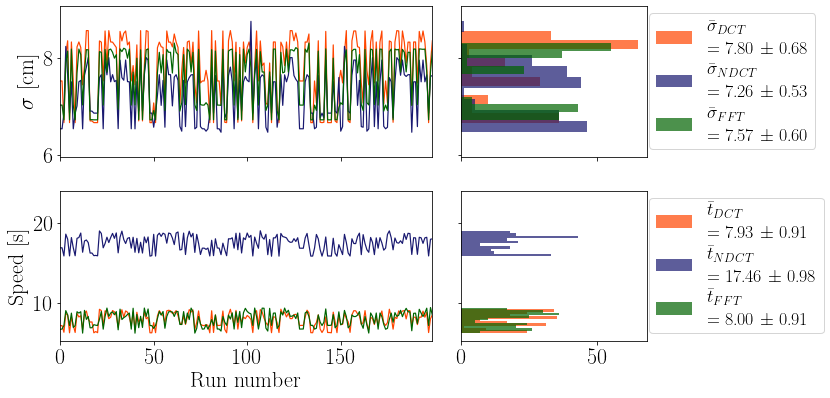

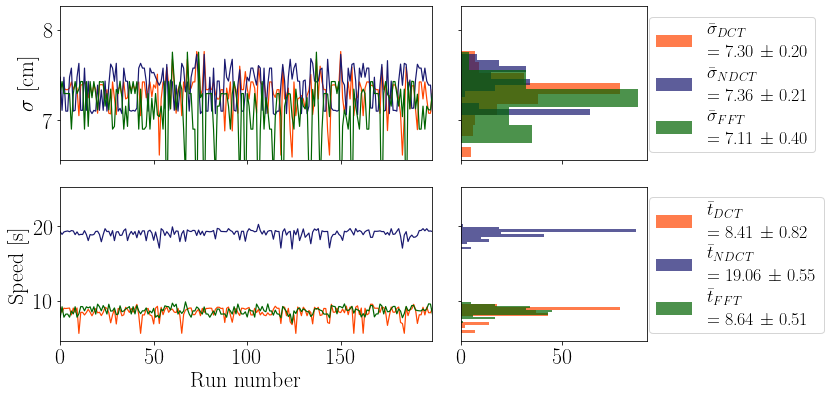

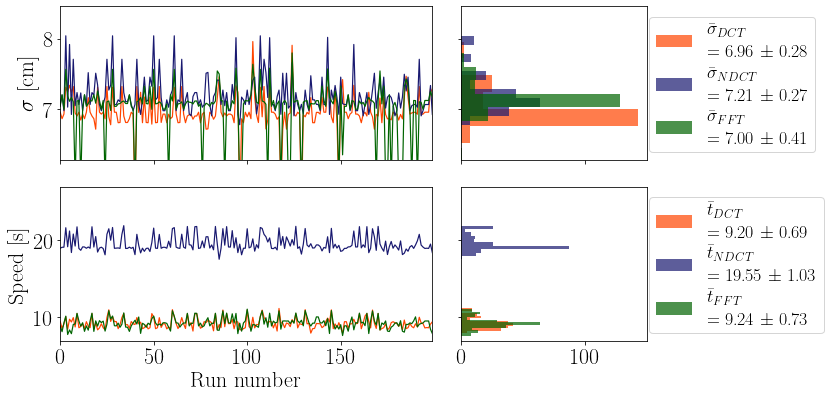

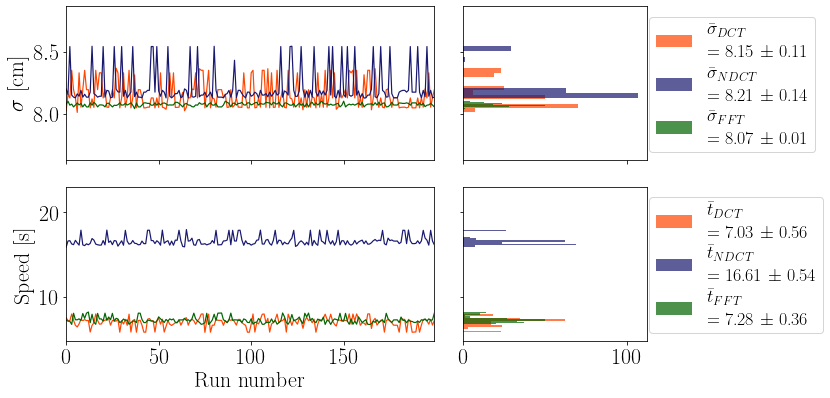

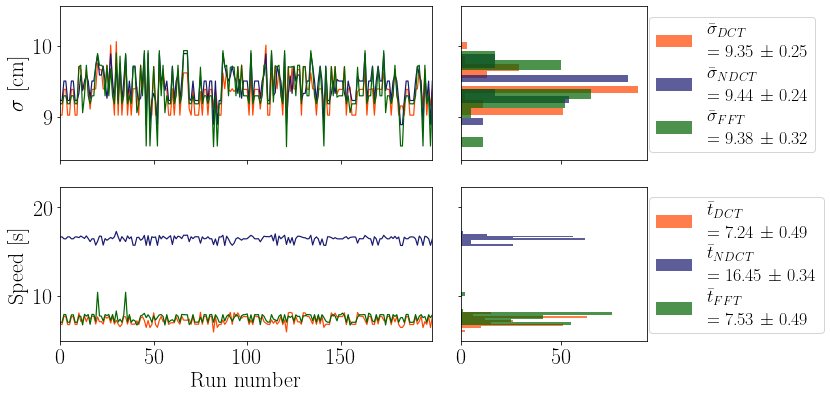

In [4]:
x = np.arange(0,len(dTambs))

for site in sites:
    dTambs,dLakis, diffLenDCTs, diffLenNDCTs, diffLenFFTs, totalDCTs, totalNDCTs, totalFFTs = np.array(pd.read_csv(pathResults + site+'_diffLens_SpecTransEffect_wTiming_varyLandT.csv', ' ', header=None))

    fig, ax = plt.subplots(2,2, figsize=(12,6), sharex='col', sharey='row', gridspec_kw={'width_ratios':[2,1]})
    sigDCT = ax[0,0].plot(x,diffLenDCTs*100, label=r'$\bar{\sigma}_{DCT}=$', c='orangered', lw=1.2)
    sigNDCT = ax[0,0].plot(x,diffLenNDCTs*100, label=r'$\sigma_{NDCT}$', c='midnightblue', lw=1.2)
    sigFFT = ax[0,0].plot(x,diffLenFFTs*100, label=r'$\sigma_{FFT}$', c='darkgreen', lw=1.2)
    ax[0,0].set(xlim=(min(x),max(x)), ylim=(min(diffLenNDCTs*100)-0.5,max(diffLenDCTs*100)+0.5), ylabel = '$\sigma$ [cm]')
    ax[0,1].hist(diffLenDCTs*100, orientation='horizontal', alpha=0.7, color='orangered', label=r'$\bar{\sigma}_{DCT}$' + f'\n = {np.mean(diffLenDCTs*100):.2f} $\pm$ {np.std(diffLenDCTs*100):.2f}')
    ax[0,1].hist(diffLenNDCTs*100, orientation='horizontal', alpha=0.7, color='midnightblue', label=r'$\bar{\sigma}_{NDCT}$' + f'\n = {np.mean(diffLenNDCTs*100):.2f} $\pm$ {np.std(diffLenNDCTs*100):.2f}')
    ax[0,1].hist(diffLenFFTs*100, orientation='horizontal', alpha=0.7, color='darkgreen', label=r'$\bar{\sigma}_{FFT}$' + f'\n = {np.mean(diffLenFFTs*100):.2f} $\pm$ {np.std(diffLenFFTs*100):.2f}')
    ax[0,1].legend(fontsize=18, loc = (1.01,0.05))

    tDCT = ax[1,0].plot(x, totalDCTs, c='orangered', lw=1.2)
    tNDCT = ax[1,0].plot(x, totalNDCTs, c='midnightblue', lw=1.2)
    tFFT = ax[1,0].plot(x, totalFFTs, c='darkgreen', lw=1.2)
    ax[1,0].set(xlim=(min(x),max(x)), ylim=(min(totalDCTs)-1,max(totalNDCTs)+5), xlabel='Run number', ylabel='Speed [s]')
    ax[1,1].hist(totalDCTs, orientation='horizontal', alpha=0.7, color='orangered',label=r'$\bar{t}_{DCT}$'+f'\n = {np.mean(totalDCTs):.2f} $\pm$ {np.std(totalDCTs):.2f}')
    ax[1,1].hist(totalNDCTs, orientation='horizontal', alpha=0.7, color='midnightblue',label=r'$\bar{t}_{NDCT}$'+f'\n = {np.mean(totalNDCTs):.2f} $\pm$ {np.std(totalNDCTs):.2f}')
    ax[1,1].hist(totalFFTs, orientation='horizontal', alpha=0.7, color='darkgreen',label=r'$\bar{t}_{FFT}$'+f'\n = {np.mean(totalFFTs):.2f} $\pm$ {np.std(totalFFTs):.2f}')
    ax[1,1].legend(fontsize=18, loc = (1.01,0.05))
    #handles, labels = ax[0,0].get_legend_handles_labels()
    #fig.legend((sigDCT, sigNDCT, sigFFT), ('DCT', 'NDCT','FFT'))#, loc = (0.5, 0), ncol=5 )
    #fig.legend(handles,labels, fontsize=16, loc=(0.84,0.475))
    fig.tight_layout()
    


### FFT

### DCT

### NDCT

# Constraints

### No constraints

### Constrained

# $\sigma_{const}$ v $\sigma(z)$

### $\sigma_{const}$

$\sigma(z)$

In [2]:
CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')
coreNames = CoresSpecs['CoreName']
site = 'Crete'

core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]

dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
bdot0 = CoreSpecs['Accum0']
Temp0 = CoreSpecs['T0']+273.15
dens0 = CoreSpecs['dens0']
z0 = CoreSpecs['z0']


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


FileNotFoundError: [Errno 2] No such file or directory: '/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDiff/Crete_DepthDiffVas.txt'

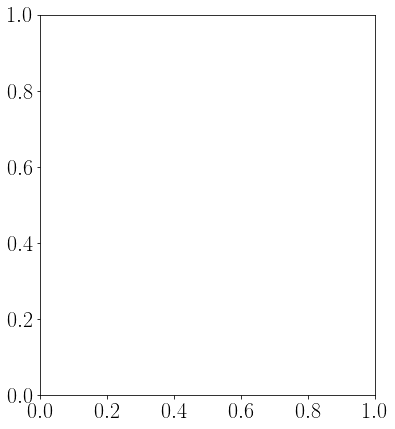

In [3]:
figDiff, axDiff= plt.subplots(figsize=(6,7))

sigmas = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDiff/' + site + '_DepthDiffVas.txt','\t')
sigma_arr = sigmas['sigma_o18']
z_vec = sigmas['Depth']


sigmas2 = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDiff/' + site + '_DepthDiffThea.txt','\t')
sigma_arr2 = sigmas2['sigma_o18']
z_vec2 = sigmas2['Depth']

TambDepth = dTamb
LakiDepth = dLaki
z_LT = z_vec[(z_vec >= TambDepth) & (z_vec <= LakiDepth)]
sigma_LT = np.asarray(sigma_arr[(z_vec >= TambDepth) & (z_vec <= LakiDepth)])
z_LT2 = z_vec2[(z_vec2 >= TambDepth) & (z_vec2 <= LakiDepth)]
sigma_LT2 = np.asarray(sigma_arr2[(z_vec2 >= TambDepth) & (z_vec2 <= LakiDepth)])

axDiff.invert_yaxis()
#axDiff.plot(sigma_arr,z_vec, 'b', lw=1, label = 'Vas')
axDiff.plot(sigma_arr2,z_vec2, 'b', lw=1)
axDiff.plot(sigma_LT,z_LT, 'k', lw=3)
axDiff.plot(sigma_LT2,z_LT2, 'k', lw=3, label=r'$\bar{\sigma}_{LT}$'+f': [{sigma_LT[0]:.3f};{sigma_LT[-1]:.3f}]')
axDiff.axhline(y = TambDepth, alpha=0.8, color='k', ls='--', lw=1.5)
axDiff.axhline(y = LakiDepth, alpha=0.8, color='k', ls='--', lw=1.5)
axDiff.axvline(x = sigma_LT[0], alpha=0.8, color='k', ls='--', lw=1.5)
axDiff.axvline(x = sigma_LT[-1], alpha=0.8, color='k', ls='--', lw=1.5,)
axDiff.set(xlabel='Diffusion Length $\sigma$ [m]', ylabel='Ice depth [m]',title=site)
axDiff.grid(True, color='grey',ls='-.')
axDiff.legend()
figDiff.tight_layout()

pathFigures = '/home/thea/MesterTesen/WrittenWork/Figures/'

figDiff.savefig(pathFigures+site+'_DiffProf_Sigz.pdf', bbox_inches='tight')

In [4]:

# Define data under examination
x_arr = z_LT
y_arr = sigma_LT*100

# Define objective function 
def fct(x,a,b,c):
    return a*(x**2) + b*x + c

# Fit curve to data
from scipy.optimize import curve_fit
popt, test = curve_fit(fct, x_arr, y_arr)

a, b, c = popt

NameError: name 'z_LT' is not defined

In [76]:
residuals = y_arr - fct(x_arr,*popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_arr - np.mean(y_arr))**2)
r2 = 1 - (ss_res / ss_tot)
r2

0.9999983816396835

In [77]:
core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']


DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']
N_InInt = 32

<ipython-input-77-95f8a327b496>:7: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  DataAll = GetCoreData(site, 'Alphabet')


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


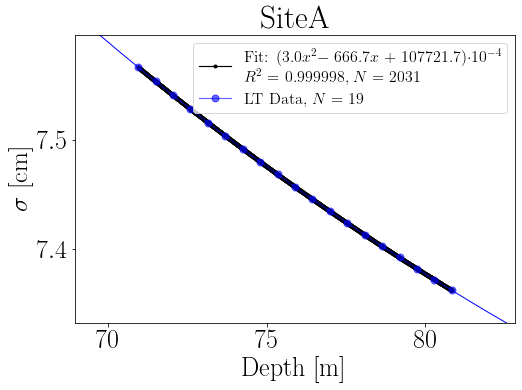

In [78]:
Npoints = 2032-1
delta = (max(z_LT) - min(z_LT))/Npoints
xTest = np.arange(min(z_LT),max(z_LT)+delta,delta)
yTest = fct(xTest, a, b, c)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(z_vec,sigma_arr*100, 'b', lw=1)
ax.set_ylabel('$\sigma$ [cm]')
ax.set_xlabel('Depth [m]')

ax.plot(xTest,yTest, color='k', lw=1.2, marker='.', label=f'Fit: ({a*10**4:.1f}'+'$x^2-$'+f' {-b*10**4:.1f}$x$' + f' + {c*10**4:.1f})'+'$\cdot 10^{-4}$'+f'\n$R^2$ = {r2:.6f}, $N=$ {Npoints}')
ax.plot(z_LT,sigma_LT*100, color='b', lw=1.2, marker='.', ms=14, label=f'LT Data, $N =$ {len(z_LT)}', alpha=0.6)
ax.set(ylim=(min(sigma_LT*100)-0.03, max(sigma_LT*100)+0.03),xlim=(min(z_LT)-2, max(z_LT)+2), title=site)
ax.legend(fontsize=16)
fig.tight_layout()

fig.savefig(pathFigures+site+'_sigmaz_fit.pdf', bbox_inches='tight')

In [79]:
from Decon import SpectralDecon
sigmaFct = (fct(xTest, *popt))/100
sigma1 = min(sigmaFct)
sigma2 = max(sigmaFct)


In [80]:
inst = SpectralDecon(np.asarray(depth_LT), np.asarray(d18O_LT),2000)

In [81]:

x,y=inst.deconvolve(sigmaFct)
x1,y1=inst.deconvolve(sigma1)
x2,y2=inst.deconvolve(sigma2)

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


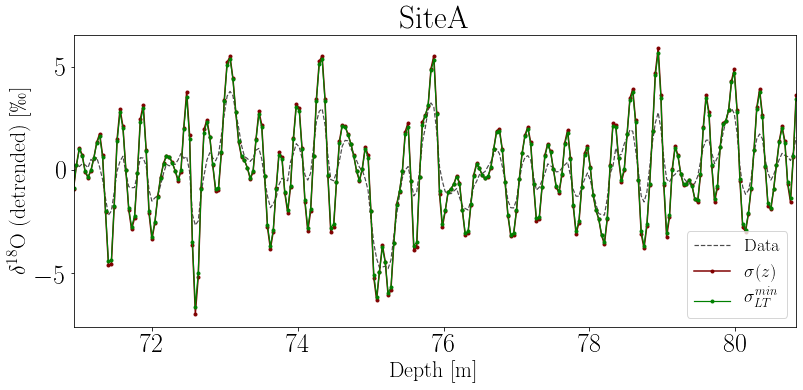

In [82]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(depth_LT,d18O_LT-np.mean(d18O_LT), lw=1.2, ls='--', color='k', alpha=0.7, label='Data')
#ax.plot(x2,y2,label='$\sigma_{LT}^{max}$', lw=1.2, c='b')
ax.plot(x,y, label='$\sigma(z)$', c='maroon', lw=1.5, marker='.')
ax.plot(x1,y1,label='$\sigma_{LT}^{min}$', c='g', lw=1.2, marker='.')


ax.set(xlim=(min(depth_LT),max(depth_LT)), title=site)
ax.legend(fontsize=18, loc='lower right')
ax.set_xlabel('Depth [m]', fontsize=22)
ax.set_ylabel('$\delta^{18}$O (detrended) [$\permil$]', fontsize=22)
fig.tight_layout()
fig.savefig(pathFigures+site+'_sigmaz_v_sigmaMin.pdf', bbox_inches='tight')

# $\sigma_{theo}$, $\sigma_{fit}$ and $\sigma_{fin}$

In [83]:
CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [84]:
site = 'SiteB'

core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']


DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']
N_InInt = 33

<ipython-input-84-15f1ae844980>:9: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  DataAll = GetCoreData(site, 'Alphabet')


In [85]:
dataAll = pd.DataFrame({'depth':depth_LT,'d18O':d18O_LT}, index=None)

inst = BackDiffuse(site, data_d18O_LT, CoresSpecs, dTamb, dLaki, N_InInt, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT)
#dataMin, peaksMin, N_peaksMin, dataMax, peaksMax, N_peaksMax = inst.BackDiffuse_Theo()
allData_TheoMin, idxPeak0, N_peaks0, idxTrough0, N_troughs0, diffLenTheo0, allData_TheoMax, idxPeak1, N_peaks1, idxTrough1, N_troughs1, diffLenTheo1 =inst.BackDiffuse_Theo()

#depthOpt, dataOpt, diffLen, peaks, arr_DiffLens, arr_Npeaks, arr_depth, arr_data = inst.backDiffused(theoDiffLen=True,print_Npeaks=False, diffLenStart_In=0.005, diffLenEnd_In=0.15, interpAfterDecon=True)
depthOpt, dataOpt, diffLen, peaks, newTs, newPattern = inst.BackDiffused_constraints()

Theo. sigma Min: 7.58 [cm]
Theo. sigma Max: 7.80 [cm]
ALT file exists. Loading ALT data.
Sigma fit: 7.58
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
4.0
Final sigma: 7.35 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.019


In [86]:
def find_constrainedPeaks(data, dist, prom):

        # Find peaks and troughs in data, given distance and prominence provided
    peaksBD = sp.signal.find_peaks(data, distance = dist, prominence=prom)[0]
    troughsBD = sp.signal.find_peaks(-data, distance = dist, prominence=prom)[0]


        # Create lists of ones (representing peaks) and zeros (representing troughs)
    peaksBD_lst = np.ones(len(peaksBD))
    troughsBD_lst = np.zeros(len(troughsBD))


        # Create array containing (unsorted) peaks and troughs positions and corresponding P (1) or T (0).
    exts = np.concatenate((peaksBD,troughsBD))
    exts_lst = np.concatenate((peaksBD_lst,troughsBD_lst))
        # Sort both lists at the same time, thus matching up idxs and P/T (1/0) value
    list1, list2 = (np.array(t) for t in zip(*sorted(zip(exts, exts_lst))))


        # Check if list is divisible by two. If not, append P/T array with -1 and idx array with 0
        # at either first or last position depending on starting with P (1) or T (0)
    if len(list1)%2 != 0:
        if list2[0] == 1:
            listNew_lst = np.append(list2,-1)
            listNew = np.append(list1,0)
        elif list2[0] == 0:
            listNew_lst = np.insert(list2,0,-1)
            listNew = np.insert(list1,0,0)
    else:
        listNew_lst = list2
        listNew = list1


        # Reshape arrays into 2 x len(Ps/Ts)
    PTs = listNew_lst.reshape((int(len(listNew_lst)/2)),2)
    PTs_idx = listNew.reshape((int(len(listNew)/2)),2)


        # Get only positive values from list (remove the appended values from earlier)
    listNew_lstPos = listNew_lst[listNew_lst>=0]
    listNew_Pos = listNew[listNew_lst>=0]


        # If the first value in the array is a peak (1), make lists with all (estimated) peaks (every second
        # element) and all troughs (every second + 1 element)
    if listNew_lstPos[0] == 1:

        listNew_lstPs = listNew_lstPos[::2]
        listNew_Ps = listNew_Pos[::2]

        listNew_lstTs = listNew_lstPos[1::2]
        listNew_Ts = listNew_Pos[1::2]

        # If the first value in the array is a trough (0), make list with all (estimated) peaks (every second
        # + 1 element) and all troughs (every second element)
    elif listNew_lstPos[0] == 0:
        listNew_lstPs = listNew_lstPos[1::2]
        listNew_Ps = listNew_Pos[1::2]

        listNew_lstTs = listNew_lstPos[::2]
        listNew_Ts = listNew_Pos[::2]


        # Check if [..PTPTPTPTPT..] pattern exists by summing all estimated peaks and checking if sum(P) == len(Ps)
        # and summing all estimated troughs and checking if sum(T) == 0
        # If so, return pattern = True and what the pattern starts and ends with (P=1 and T=0)

    if (sum(listNew_lstPs) == len(peaksBD)) & (sum(listNew_lstTs) == 0):
        pattern = True
        patternStart = listNew_lstPos[0]
        patternEnd = listNew_lstPos[-1]
        # If not, return pattern = False and start and end as empty lists.
    else:
        pattern = False
        patternStart = []
        patternEnd = []

    return pattern, patternStart, patternEnd, listNew_Ps, listNew_Ts

0      -4.879537
1      -3.691254
2      -2.409913
3      -1.101863
4       0.166550
          ...   
1051    1.396551
1052    0.622696
1053   -0.241394
1054   -1.143074
1055   -2.029702
Name: d18O, Length: 1056, dtype: float64

In [93]:
data0 = allData_TheoMin['d18O']
data1 = allData_TheoMax['d18O']

Pattern0, pS0, pE0, idxPeak0, idxTrough0 = find_constrainedPeaks(data0, dist=4, prom=np.std(data0)*.5)
Pattern1, pS1, pE1, idxPeak1, idxTrough1 = find_constrainedPeaks(data1, dist=4, prom=np.std(data1)*.5)

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


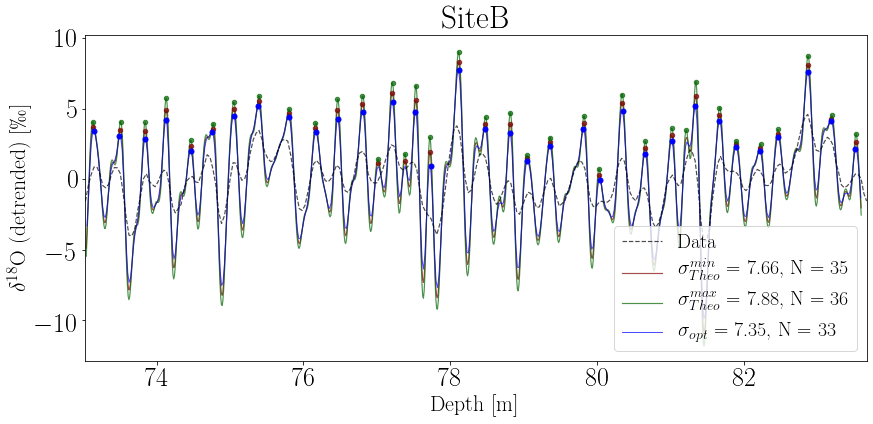

In [94]:
depth0 = allData_TheoMin['depth']
data0 = allData_TheoMin['d18O']
depth1 = allData_TheoMax['depth']
data1 = allData_TheoMax['d18O']
#troughs = signal.find_peaks(-dataOpt)[0]
mpl.rcParams['font.size'] = 26

fig, ax = plt.subplots(figsize=(14,6))

plt.plot(np.asarray(depth_LT), np.asarray(d18O_LT)-np.mean(np.asarray(d18O_LT)), lw=1.2, label='Data', ls='--', color='k', alpha=0.7)
plt.plot(depth0,data0, label='$\sigma_{Theo}^{min}$ = ' + f'7.66, N = {len(idxPeak0)}',zorder=-1, color='maroon', alpha=0.7, lw=1.2)
plt.plot(depth1,data1, label='$\sigma_{Theo}^{max}$ = ' + f'7.88, N = {len(idxPeak1)}',zorder=-1, color='darkgreen', alpha=0.7, lw=1.2)
plt.plot(depthOpt, dataOpt, label='$\sigma_{opt}$ = ' + f'{diffLen*100:.2f}, N = {len(peaks)}',zorder=-1, color='b', alpha=.7, lw=1)
#, Nt = {len(troughs)}
plt.legend(fontsize=20)
ax.set(title=site,xlim=(min(depth_LT),max(depth_LT)))
ax.set_xlabel('Depth [m]', fontsize=22)
ax.set_ylabel('$\delta^{18}$O (detrended) [$\permil$]', fontsize=22)
plt.scatter(depth0[idxPeak0],data0[idxPeak0], color='maroon',zorder=1, s=20, alpha=0.7)
plt.scatter(depth1[idxPeak1],data1[idxPeak1], color='darkgreen',zorder=1, s=20, alpha=0.7)
plt.scatter(depthOpt[peaks],dataOpt[peaks], color='b',zorder=1, s=25)
#plt.scatter(depthOpt[troughs],dataOpt[troughs], color='k',zorder=1, s=25)


fig.savefig(pathFigures+site+'_TheoDiffLens.pdf', bbox_inches='tight')

# Final $\sigma$ estimate

Final estimate is based on a constrained, NDCT(uniform resampling) method with interpolation after deconvolution.

### Example of final BD depth series

In [5]:
site = 'Crete'
N_InInt = 33

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
accum0 = CoreSpecs['Accum0']
accumIE = CoreSpecs['Accum1']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth = data_d18O['depth']
d18O = data_d18O['d18O']

depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']


No ECM file found, setting empty df instead


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-5-d94deb82c1b0>:17: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  DataAll = GetCoreData(site, 'Alphabet')


In [6]:
dataAll = pd.DataFrame({'depth':depth,'d18O':d18O}, index=None)

In [7]:
instNDCT = BackDiffuse(site, dataAll, CoresSpecs, dTamb, dLaki, N_InInt, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT, Dist=30, transType = 'NDCT')

depNDCT, datNDCT, diffNDCT, PsNDCT, TsNDCT, patsNDCT = instNDCT.BackDiffused_constraints()

ALT file exists. Loading ALT data.
Sigma fit: 7.20
Min sigma analyt: 7.28
Starting sigma: 5.20 [cm]
6.0
Final sigma: 7.22 [cm]
Final # of peaks: 33
Delta: 0.026
Delta new: 0.013


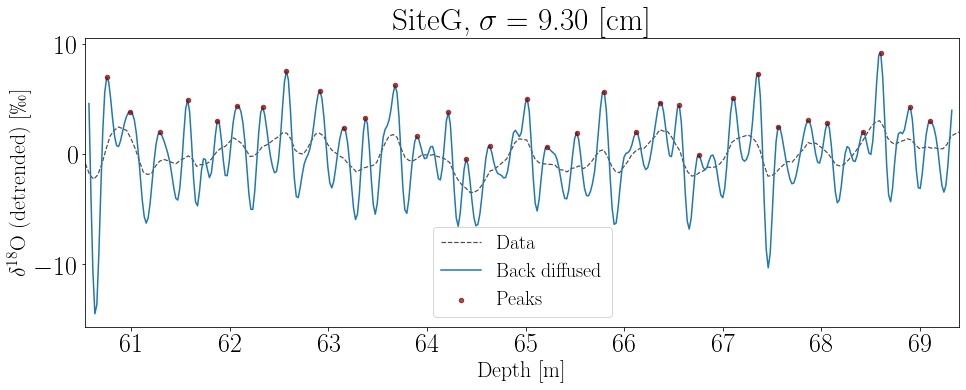

In [114]:

fig, ax = plt.subplots(figsize=(14,6))

ax.plot(np.asarray(depth_LT), np.asarray(d18O_LT)-np.mean(np.asarray(d18O_LT)), lw=1.2, label='Data', ls='--', color='k', alpha=0.7)
ax.plot(depNDCT,datNDCT, label='Back diffused')
ax.scatter(depNDCT[PsNDCT],datNDCT[PsNDCT], color='maroon', s=20, alpha=0.7, zorder=3, label='Peaks')

ax.set(title=site+f', $\sigma=$ {diffNDCT*100:.2f} [cm]',xlim=(min(depth_LT),max(depth_LT)))
ax.set_xlabel('Depth [m]', fontsize=22)
ax.set_ylabel('$\delta^{18}$O (detrended) [$\permil$]', fontsize=22)


ax.legend(fontsize=20)

fig.tight_layout()
fig.savefig(pathFigures+site+'_BDdata.pdf', bbox_inches='tight')